In [1]:
#-------- IMPORT BASIC LIBRARIES
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# For timeseries RNN LSTM neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [3]:
# -------- IMPORT KERAS: TimeseriesGenerator
# This class produces time series batches used on training/testing the model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# -------- IMPORT KERAS: MinMaxScaler
# This class is used to preprocess (scale) the data
from sklearn.preprocessing import MinMaxScaler

Dataset: NVIDIA Stock:(8/20/2019 - 8/20/2024)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving NVDA.csv to NVDA.csv


**Load Dataset**

In [5]:
df_ALL = pd.read_csv("NVDA.csv")


In [6]:
df_ALL.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-08-20,4.26400,4.26450,4.17550,4.19675,4.172663,463188000
1,2019-08-21,4.26325,4.33625,4.24150,4.28075,4.256181,427244000
2,2019-08-22,4.29050,4.33325,4.24750,4.28700,4.262394,303488000
3,2019-08-23,4.21000,4.26475,4.04100,4.06100,4.037691,568056000
4,2019-08-26,4.14025,4.16450,4.09775,4.13625,4.112510,318208000


In [7]:
df_ALL.shape

(1259, 7)

In [8]:
df_ALL.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj Close,float64
Volume,int64


In [9]:
# Statistics Summary
df_ALL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,29.162385,29.719072,28.567671,29.177584,29.155562,4.526983e+08
std,28.492366,29.043974,27.837172,28.478431,28.485383,1.849680e+08
min,4.014500,4.083500,3.975000,4.030500,4.011334,9.788400e+07
25%,12.943750,13.155125,12.706500,12.923375,12.893522,3.188960e+08
50%,18.472000,18.968000,18.122000,18.648001,18.623581,4.275020e+08
75%,32.483500,33.188501,31.642500,32.550499,32.499474,5.506505e+08
max,139.800003,140.759995,132.419998,135.580002,135.580002,1.543911e+09


**Keep only the close column**

In [10]:
df = df_ALL.iloc[:, 4:5]

In [11]:
df.head()

,Close
0,4.19675
1,4.28075
2,4.28700
3,4.06100
4,4.13625


<Axes: >

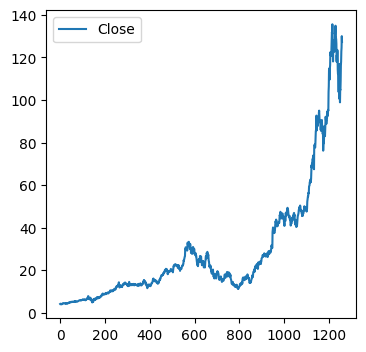

In [12]:
df.plot(figsize=(4, 4))

Length of input time series- Number of inputs time steps

In [13]:
# Set the length of the input sequence
# i.e., the number of time series steps that are used to predict the future one
# Currently use 60 historical data points to predict the next one
# It means that 60 consecutive closing prices will be used to predict the next one
length60 = 60

In [14]:
length60

60

Time Series Dataset: Train / test Split

In [15]:
len(df)

1259

In [16]:
# Set percentage of data used for testing
test_percent = 0.1

In [17]:
# Number of data points reserved for testing the model
# 20% of the original dataset
len(df) * test_percent

125.9

**Split Data - Train/Test**

In [18]:
# Need to find the length (number of data points) of the testing dataset
# It has been found (above) that around 205 data points are used for testing

test_length = np.round(len(df) * test_percent)

test_length

126.0

In [19]:
# The testing data set starts at this index

split_index = int(len(df) - test_length)

split_index

1133

In [20]:
# Create separate training / testing datasets

# Training dataset: All the indices from start to split_index
# (excluding split_index)
data_train = df.iloc[:split_index]

# Testing dataset:
# -> All the indices from (split_index - length60) to the end of the dataframe
# -> split_index - length60: Need the last 60 historical data points (belong to data_train)
#    to predict the first data point of the data_test
data_test = df.iloc[split_index - length60:]

In [21]:
data_train.head(5)

,Close
0,4.19675
1,4.28075
2,4.28700
3,4.06100
4,4.13625


In [22]:
data_train.tail()

,Close
1128,72.127998
1129,73.900002
1130,72.657997
1131,72.612999
1132,69.452003


In [23]:
data_test.head(5)

,Close
1073,48.716000
1074,47.776001
1075,48.242001
1076,47.820999
1077,48.139999


In [24]:
data_test.tail()

,Close
1254,118.080002
1255,122.860001
1256,124.580002
1257,130.000000
1258,127.250000


**Normalize Data (Scale it into the range [0, 1])**


In [25]:
# Create a MinMaxScaler to normalize the data
scaler = MinMaxScaler()

In [26]:
# IGNORE the warning: Just converting the data to floats
# ONLY scale the TRAINING data - NOT scale testing data

# Train the scaler to perform the normalization
scaler.fit(data_train)

MinMaxScaler()

In [27]:
# Normalize the training dataset
normalized_train = scaler.transform(data_train)

# Normalize the testing dataset
normalized_test = scaler.transform(data_test)

**Create TimeseriesGenerator for Training**

In [28]:
# TimeseriesGenerator: Generate time series batches for training/testing

# Set the length of the input sequence as above
# length60

# batch_size: Number of time series samples in each batch
# Sample: A single time series input that has 60 historical data points
batch_size32 = 32

# Create a TimeSeriesGenerator for training: train_tsGenerator
# -> This time series generator produces time series batches used to train the model
# TimeseriesGenerator(inputs, outputs, length, batch_size)
# -> Normally: INPUTS & OUTPUTS are the same dataset during training & testing/validation
train_tsGenerator60 = TimeseriesGenerator(normalized_train, normalized_train, length=length60, batch_size=batch_size32)

In [29]:
len(normalized_train)

1133

In [30]:
len(train_tsGenerator60)

34

In [31]:
# What does the first batch look like?
X, y = train_tsGenerator60[0]

In [32]:
#print(X)

In [33]:
#print(y)

**Build LSTM Model**

In [34]:
# Set number of features
# Feature: Attribute/Variable of the data set - used as predictors

# Only using one feature: Close price
n_features = 1

In [35]:
# define model
model = Sequential()

# Add an LSTM layer
# This layer has 50 LSTM cells
# Activation function: relu
# MUST: return_sequences=True
# -> Because of multiple LSTM layers: the layers are stacked
# -> Outputs = inputs of the next LSTM layer
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length60, n_features)))

# Dropout layer
model.add(Dropout(0.2))

# Add 2nd LSTM layer
# MUST: return_sequences=True
# -> Because of multiple LSTM layers: the layers are stacked
# -> Outputs = inputs of the next LSTM layer
model.add(LSTM(units=50, activation='relu', return_sequences=True))

# Dropout layer
model.add(Dropout(0.2))

# Add 3rd LSTM layer
model.add(LSTM(units=50, activation='relu'))

# Add a FC (fully-connected) layer for the final prediction
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


***Compile model***

In [36]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

Train(Fit) Model using fit_generator()

In [37]:
model.fit(train_tsGenerator60, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.0644
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0070
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0038
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0018
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0013
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0029
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0027
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0052
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0014
Epoch 13/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0023
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0019
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0084

**Visualize Model's Performance after Training**

In [38]:
loss_history_keys = model.history.history.keys()

# model.history.history is a dict
# 'loss': its key
# 'Loss': loss during training
loss_history_keys


dict_keys(['loss'])

<Axes: >

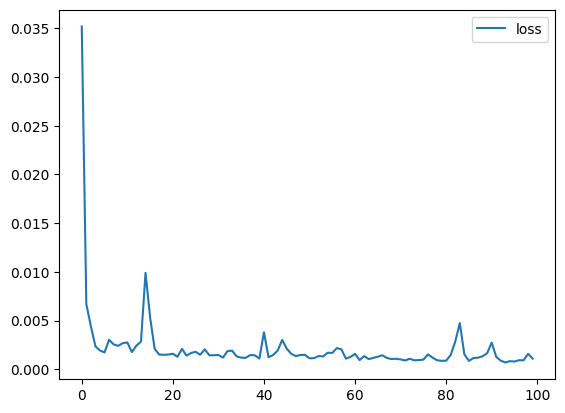

In [39]:
# Load the loss data (model.history.history) into a data frame
df_model_loss = pd.DataFrame(model.history.history)

# Visualize the loss data using DataFrame.plot()
df_model_loss.plot()

**Prediction for Testing: Using TimeseriesGenerator**

Create TimeseriesGenerator for Testing

In [40]:
# batch_size MUST be 1
batch_size1 = 1

# Create a TimeSeriesGenerator for testing: test_tsGenerator
test_tsGenerator60 = TimeseriesGenerator(normalized_test, normalized_test, length=length60, batch_size=batch_size1)

Predict Future Data Points for Testing

In [41]:
normalized_prediction = model.predict(test_tsGenerator60)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [42]:
# Prediction is a numpy 2D array with only one column
normalized_prediction

array([[1.0097553],
       [1.0058141],
       [1.0091188],
       [1.0197024],
       [1.0356127],
       [1.0534778],
       [1.0696592],
       [1.0845302],
       [1.1010491],
       [1.1214677],
       [1.1444515],
       [1.1708244],
       [1.2026215],
       [1.2296349],
       [1.2480575],
       [1.2661978],
       [1.2822465],
       [1.292185 ],
       [1.2968313],
       [1.29839  ],
       [1.2992975],
       [1.3013834],
       [1.3058664],
       [1.3155841],
       [1.3294487],
       [1.3420051],
       [1.3492283],
       [1.351913 ],
       [1.3512872],
       [1.3475071],
       [1.3414472],
       [1.3305975],
       [1.3199795],
       [1.3095777],
       [1.2981402],
       [1.288945 ],
       [1.2866503],
       [1.2867279],
       [1.2854787],
       [1.2846452],
       [1.2798659],
       [1.2732064],
       [1.2554032],
       [1.2347176],
       [1.2174677],
       [1.2014188],
       [1.1909691],
       [1.1915298],
       [1.2003826],
       [1.2125548],


In [43]:
len(normalized_prediction)

126

In [44]:
# Convert normalized predictions back to the true values
prediction = scaler.inverse_transform(normalized_prediction)

In [45]:
# Flatten all the 2D array

# data_train = data_train.reshape((-1))
# data_test = data_test.reshape((-1))
# prediction = prediction.reshape((-1))

prediction_index = np.arange(1133, 1259, step=1)

df_prediction = pd.DataFrame(data=prediction, index=prediction_index, columns=['Prediction'])

In [46]:
df_prediction

,Prediction
1133,74.581596
1134,74.306229
1135,74.537125
1136,75.276596
1137,76.388245
...,...
1254,117.693489
1255,119.687218
1256,122.740433
1257,126.403252


Visualize Predicted Values

<Axes: >

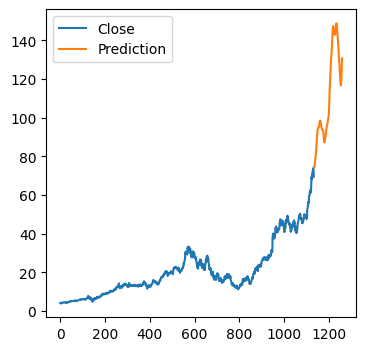

In [47]:
ax = data_train.plot()

df_prediction.plot(ax=ax, figsize=(4, 4))

Visualize prediction and compare with actual prices

<Axes: >

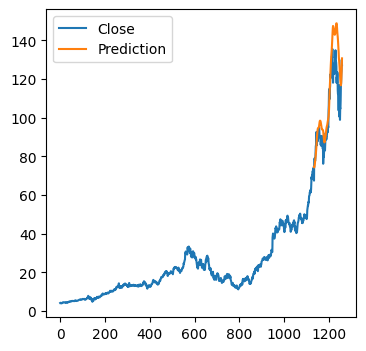

In [48]:
ax = df.plot()

df_prediction.plot(ax=ax, figsize=(4, 4))

**Time Series Forecasting with LSTM**

Overview
Time series forecasting:
-> Forecast into the "future" or unknown range
-> Should employ all the available data
-> i.e., NOT split the data into training/testing

**Preprocess Full Input Dataset**

In [49]:
# Still use MinMaxScaler to normalize the full input dataset df
full_scaler = MinMaxScaler()
normalized_full_data = full_scaler.fit_transform(df)

**Create TimeSeriesGenerator for Forecasting**

In [50]:
# Number of time steps of the input time series
# Still use length60:
length60

60

In [51]:
# Create Timeseries Generator for forecasting
forecast_tsGenerator = TimeseriesGenerator(normalized_full_data, normalized_full_data, length=length60, batch_size=batch_size32)

**Build, Compile, and Fit LSTM Model for Forecasting**

In [ ]:
# Train/Fit LSTM model
# In forecasting, we don't validate, only FORECAST
# So, not need EarlyStop; Not need validation_generator

model.fit(forecast_tsGenerator, epochs=100)

Epoch 1/100
 7/38 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.3122e-04

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 6.1786e-04
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0040
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0033
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0029
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0053
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.7937e-04
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0111e-04
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.8482e-04
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 7.6375e-04
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.2020e-04
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.9435e-04
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.9109e-04
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.0244e-04
Epoch 15/100
38/38 ━━━━━━━━━━━━━━

**Time Series Forecast Using LSTM Neural Network (8/20/2024 - 12/05/2024)**

In [ ]:
forecast = []

# Set periods with the time span of forecasting
# Let's forecast for the next 107 business days (4/26/2024 - 08/09/2024)
periods = 107

first_eval_batch = normalized_full_data[-length60:]
current_batch = first_eval_batch.reshape((1, length60, n_features))

for i in range(periods):
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]

    # store prediction
    forecast.append(current_pred)

    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

**Inverse to Transform Normalized Data Back into True Values**

In [ ]:
forecast = full_scaler.inverse_transform(forecast)

forecast

In [ ]:
df

**Creating new timestamp index with panda **

In [ ]:
# Calculate forecast index
forecast_index = np.arange(1259, 1366, step=1)


In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [ ]:
forecast_df

**Plot the Forecast**

In [ ]:
df.plot()
forecast_df.plot()

**Joining Pandas Plots**

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(4, 4))